# Tutorial Example

In this tutorial example, we walk through all the steps of solving an optimal control problem using YAPSS, in this case, the brachistochrone problem with a path constraint. The steps are:

1. Installation and configuration
1. Problem formulation and instantiation
1. Definition of callback functions needed to define the performance objective function, systems dynamics,
   path and endpoint constraints, etc.
1. Specification of bounds on the decision variables (the states, control inputs, and parameters), as well
   as bounds on only path variables and integrals over each phase of the problem.
1. Setting of the options that govern the behavior of the YAPSS solver, and of the underlying NLP solver
   Ipopt.
1. Solving the problem and extracting the solution.

This tutorial is written in a JupyterLab notebook. For a solution to the brachistochrone problem using a Python script instead of a notebook, see the brachistochrone problem [Python script documentation](../scripts/brachistochrone.rst).

## Installation and Configuration

Installation is straightforward on machines with macOS, Linux, or Windows operating systems. In a terminal window,
```console
$ pip install yapss
```
or
```console
$ conda install -c conda-forge yapss
```
Many of the examples provided (including this tutorial) are JupyterLab Notebooks. 
```console
$ pip install jupyterlab jupyterlab-code-formatter jupyterlab-spellchecker black isort
```
or use the similar conda command. (Only jupyterlab is needed, but the other packages are helpful.) Then in the directory where the notebooks are, launch JupyterLab by entering
```console
$ jupyter lab
```
and open the desired notebook, or start a new one. To test your setup, execute the cell

In [1]:
try:
    import yapss

    print("YAPSS is installed correctly.")
except ImportError:
    print("YAPSS is not installed.")

YAPSS is installed correctly.


This basic installation of YAPSS uses a version of Ipopt that (most likely) uses the linear solver MUMPS. Ipopt can be compiled with or linked to libraries with other linear solvers that can improve the performance of Ipopt, and YAPSS can be configured to take advantage of those libraries. However, the version of Ipopt in the basic installation of YAPSS is more than adequate for most purposes.

To learn more about how to configure YAPSS and IPOPT, see the [Configuring the Ipopt Source](../reference/configuration.rst) page.

## Problem Formulation and Instantiation

The problem we will solve in this tutorial is a version of the *brachistochrone* problem. The brachistochrone problem is a classic problem in the calculus of variations, posed by Johann Bernoulli in June 1696 <cite data-footcite="Bernoulli:1696"> </cite> in a challenge to the mathematicians of his time. The problem can be stated as follows: Given two points A and B in a vertical plane, what is the path that a particle, starting from rest and accelerated by a uniform gravitational force, will take to descend from A to B in the least time? Physically, we can imagine a heavy bead sliding along a wire without friction, under the action of gravity. The optimal path can be shown to have the shape of an inverted cycloid.

In this tutorial, we consider an (only slightly) more complicated version of this problem 
(see Bryson *et al.* <cite data-footcite="Bryson:1963">(Bryson, 1963)</cite>), in which the bead starts at a specific location $(x(0),y(0))=(0,0)$ in the vertical plane at time $t_0=0$, and slides to a final position $(x(t_f),y(t_f))$ at final time $t_f$. Here $x$ is the horizontal axis, and $y$ is the vertical axis, with positive $y$ down. The goal of the problem is to minimize the cost objective
$$
J = t_F
$$
subject to the constraints that that the final horizontal position of the bead satisfy
$$
x(t_f) = x_f
$$
for a given $x_f$, and that the path lies above an inclined line (a wall), so that
$$
    h(t) = y(t) - \left( c_1 x(t) + c_0 \right),\qquad 0 \le t \le t_f
$$
That is, the path must always lie above a line with (downward) slope $c_1$ and $y$ intercept $c_0$ below the origin. For this problem, we'll take $x_f = 1$ ft (about right for a tabletop brachistochrone), $c_1=\frac{1}{2}$ (a $30^\circ$ slope) and $c_0=0.1$ ft.

We take the control input at time $t$ to be $\gamma(t)$, the angle of the velocity vector below the horizontal. Bryson *et al.* give the dynamics as
$$
\begin{aligned}
    & \dot{x}(t) = (2 g y)^{1 / 2} \cos \gamma(t) \\
    & \dot{y}(t) = (2 g y)^{1 / 2} \sin \gamma(t)
\end{aligned}
$$
In this formulation, the velocity is implicitly a function of the vertical position,
$$
    v = (2 g y)^{1 / 2}
$$
which follows from conservation of energy. It turns out that it's better to keep velocity as an explicit state, so the equations of motion become
$$
\begin{align}
  \dot x(t) &= v(t) \cos \gamma(t)  \\
  \dot y(t) &= v(t) \sin \gamma(t)  \\
  \dot v(t) &= g \sin \gamma(t)
\end{align}
$$
(The problem with the first formulation is that when we take the derivatives of the state dynamics with respect to $y$, the result is proportional to $\frac{1}{\sqrt{y}}$, so that there is a singularity at the initial time.)



We're now ready to instantiate the problem. The problem has one phase, and for that phase, there are three states, $\boldsymbol{x}=(x, y, v)$, one control, $\boldsymbol{u}=\gamma$, and one path constraint function, $h$. So we instantiate the problem as follows:

In [2]:
import matplotlib.pyplot as plt
import yapss
from numpy import pi
from yapss.math import cos, sin

problem = yapss.Problem(name="Brachistochrone", nx=[3], nu=[1], nh=[1])

## Defining the Callback Functions

The next step is to define callback functions that define the state dynamics, path constraints, and objective function.

### The Objective Callback Function

We start with the objective function. The objective function can depend on a number of discrete quantities: the initial and final times of each phase, the initial and final states of each phase, the values of any integrals evaluated over each phase, and any parameters in the optimization problem. Our objective is to minimize the final time of the first (and only!) phase. So the objective function is simply:

In [3]:
def objective(arg):
    arg.objective = arg.phase[0].final_time


problem.functions.objective = objective

### The Continuous Callback Function

The continuous callback function defines the dynamics, path constraint functions, and integrands for any integrals, again for each phase. For our problem, we need to define the state dynamics and path function:

In [4]:
# define the gravitational constant (here using U.S customary units)
g0 = 32.174

# set the constants defining the barrier
problem.auxdata.c1 = c1 = 0.5
problem.auxdata.c0 = c0 = 0.1


def continuous(arg):
    # extract the elements of the state vector
    x, y, v = arg.phase[0].state

    # extract elements of the control vector. note that even though there's
    # only one control, we must still treat arg.phase[0].control as an array
    (u,) = arg.phase[0].control

    # extract the constants
    c1 = arg.auxdata.c1
    c0 = arg.auxdata.c0

    # define the state dynamics
    arg.phase[0].dynamics = [v * cos(u), v * sin(u), g0 * sin(u)]

    # define the path constraint function
    arg.phase[0].path = [y - c1 * x - c0]


problem.functions.continuous = continuous

Two subtleties should be highlighted here. First, the common math functions are provided by the ``yapss.numpy`` module which is a drop-in replacement for the numpy package. This is done to get the proper behavior when CasADi objects are used for automatic differentiation.

Second, the use of the ``auxdata`` attribute requires some explanation. We could have defined ``c_0`` and  ``c_1`` as constants just as we did ``g0``. However, by using the auxdata mechanism, we can easily change the problem, even if the problem has been defined in another module. For example, we could do this in a python console:
```python
>>> from yapss.examples.brachistochrone import setup
>>> 
>>> problem2 = setup()
>>> problem2.auxdata.c0 = 0.05
```
which would change the problem definition, without having to edit the original code.

You can learn more on the [Callback Functions](../reference/callbacks.rst) page.

## Setting Bounds

Setting the bounds is straightforward for this problem. See the comments in the code snippet below for specifics.

In [5]:
# get the bounds object for the phase, to make code below this briefer
bounds = problem.bounds.phase[0]

# Bounds for time and initial state
bounds.initial_time.lower = bounds.initial_time.upper = 0
bounds.initial_state.lower = bounds.initial_state.upper = [0, 0, 0]

# Bounds for final state in x-axis
bounds.final_state.lower[0] = bounds.final_state.upper[0] = 1

# Path constraints (should be less that or equal to 0)
bounds.path.upper = [0]

There were no constraints on the control $u(t) = \gamma(t)$. However, because $\gamma$ is an angle, its value is unique only up to mod $2\pi$. To get a unique solution, we constrain it to lie in the interval  $[-\pi/2,\pi/2]$, that is, the bead always moves in the positive $x$ direction.

In [6]:
bounds.control.lower = [-pi / 2]
bounds.control.upper = [+pi / 2]

You can learn more on the [Setting Bounds](../reference/bounds.rst) page.

## Setting the Initial Guess

Ipopt solves nonlinear programming (NLP) problems using a primal-dual interior point method. The method finds a solution to minimization problems by beginning with an initial guess for the decision variables, and iteratively approximates the NLP problem with a series of quadratic programming subproblems, which is solves to determine a search direction. By necessity, the algorithm requires an initial guess for the solution, and therefore one must be provided to YAPSS.

The initial guess provided by the user is interpolated to obtain a guess for all the discretization points, and therefore all the decision variables. For complicated problems, a good initial guess can be crucial for finding the solution. For simple problems, often a very simple guess will suffice. For this problem, we guess that the initial time and state correspond to the boundary conditions on the initial time (all of these variables are zero). We guess that the final time is $t_f = 1$, the final state is $\boldsymbol{x}_f = (1,1,1)$, and that the control is zero for all times. That's not a very good guess as it turns out, but it's enough to get a solution.

In [7]:
phase = problem.guess.phase[0]
phase.time = [0.0, 1.0]
phase.state = [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
phase.control = [[0, 0.0]]

To understand more about how the user sets the initial guess, see the [Setting the Initial Guess](../reference/guess.rst) page.

## Setting YAPSS and Ipopt Options

### YAPSS Options

There are three items that can be configured in the YAPSS solver to improve the solution, although all three have defaults that will usually yield good results.

**Derivatives.** The ``derivatives.method`` option can take on one of three values:

- **"auto"** (default), for automatic differentiation using the casadi package.
- **"central-difference"**, for derivatives calculated using central difference techniques.
- **"user"**, in which case the user must supply the first and perhaps second derivatives.

Nearly all problems are best solved using "auto" or "central-difference", and when the automatic differentiation can be used, it is usually the best choice. So we'll use the default "auto".

The ``derivatives.order`` option can take on one of two values, "first" or "second". When using automatic differentiation, it's almost always better to use "second". When using the central difference method, it can sometimes be advantageous to use only first order derivatives, because taking second derivatives is computationally expensive. So again we'll use the default value.

**Choice of Spectral Method.** The original GPOPS-II algorithm <cite data-footcite="Patterson:2014">(Patterson et al., 2014)</cite> uses Legendre-Gauss-Radau collocation points, but YAPSS implements three choices for the pseudospectral method used, set by the ``spectral_method`` option attribute:

- **"lg"**: Lagrange polynomials based on Legendre-Gauss (LG) collocation points.
- **"lgr"**: Lagrange polynomials based on Legendre-Gauss-Radau (LGR) collocation points.
- **"lgl"** (default): Lagrange polynomials based on Legendre-Gauss-Lobatto (LGL) collocation points.

As a practical matter, all have similar performance. The main drawback of LGR and LG collocation points is that one or both endpoints for each phase are not collocation points, meaning that there's no requirement that the dynamics equation be satisfied there. As a result, the values of the control input, costate, and Hamiltonian are not determined at one or both endpoints (although the state vector is). These values can be found by interpolation, but this may in values that violate the constraints on the control. For this reason, the "lgl" method is the default, and we'll use it for the example.

**Mesh Geometry.** The computational mesh for each phase consists of a number of mesh segments (of possibly varying length), each with a number of collocation points where the values of the state and control are used to calculate the dynamics, path constraint functions, and integrands of integrals over the segment. The number of collocation points can vary by segment as well.

The YAPSS default is to have 10 segments of equal length, each with 10 collocation points. For most problems, this default mesh will give very good results, yielding relative errors in the solution on the order of $10^{-8}$ or better. There are exceptions of course: (1) when there are discontinuities in the derivatives of the state (because the interpolation polynomials are best at representing smooth functions), and (2) when there are very fast timescale dynamics, often at the beginning or end of a phase. For the example problem here, the default values work pretty well, and so we won't change them.

Had we wanted to specify these defaults values explicitly, here is the code that would be used:

In [8]:
# derivatives
problem.derivatives.method = "auto"
problem.derivatives.order = "second"

# choice of basis
problem.spectral_method = "lgl"

# mesh geometry
segments, points = 10, 10
problem.mesh.phase[0].collocation_points = segments * [points]
problem.mesh.phase[0].fraction = segments * [1 / segments]

The number of collocation points in each segment ``k`` is determined by the ``mesh.phase[k].collocation_points`` attribute, and the duration of each segment (as a fraction of the duration of the phase) is determined by the ``mesh.phase[k].fraction`` attribute.

### Ipopt Options

There are *lots* of Ipopt options, and most users will end up changing very few. YAPSS uses the default [IPOPT options](https://coin-or.github.io/Ipopt/OPTIONS.html) for the most part, mostly because we don't want users who are familiar with Ipopt to be surprised by our choices. There are two exceptions:

1. In some cases, the proper functioning of Ipopt depends on specific Ipopt settings. A good example is the ``hessian_approximation``, which must be "exact" when second derivatives are used, and "limited-memory" when only first derivatives are used. In addition the mseipopt package that YAPSS uses in some cases sets ``warm_start_init_point`` to "no" because YAPSS does not (yet) provide a warm-start interface.

2. While we try not to be opinionated about Ipopt options, we do set the YAPSS default ``mu_strategy`` to "adaptive" rather than the  Ipopt default "monotone". The YAPSS test suite takes about 30% longer to run using the Ipopt default, and we find that the Ipopt solver sometimes fails to converge for difficult problems using the Ipopt default.

For this problem, we'll use the following settings:

In [9]:
# This is the YAPSS (but not Ipopt) default
problem.ipopt_options.mu_strategy = "adaptive"

# Ipopt default print_level is 5, which produces lots of output.
# 3 is the minimum level to get informative output
problem.ipopt_options.print_level = 3

# It's a good idea to show selected user options
problem.ipopt_options.print_user_options = "yes"

# Not necessary, but it can interesting to see how long it takes to solve
problem.ipopt_options.timing_statistics = "yes"

# Suppresses the Ipopt banner
problem.ipopt_options.sb = "yes"

# The default tolerance is 1e-8.
problem.ipopt_options.tol = 1e-12

See the [Ipopt Options](../reference/ipopt_options.rst) page for more information about choosing Ipopt options.

## Solution

Now that the problem is completely set up, all that remains is to find the solution.

In [10]:
solution = problem.solve()


List of user-set options:

                                    Name   Value                used
                             mu_strategy = adaptive              yes
                      nlp_scaling_method = user-scaling          yes
                             print_level = 3                     yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
                       timing_statistics = yes                   yes
                                     tol = 1e-12                 yes
Total number of variables............................:      391
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       91
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:       92
        inequality constraints with 

There's useful information about the size of the problem, number of function calls, etc., but the most important number is the "Overall NLP error". For our problem, it's really quite small (and smaller than the tolerance we asked for), so it looks like we have a good solution. Let's see how good!

It turns out the optimal minimum time can be found exactly — it's
$$
t_f = \left(\frac{2}{g}\left(\tan^{-1}c_{1}+\frac{1}{c_{1}}\right)\left(x_{f}+\frac{c_{0}}{c_{1}}\right)\right)^{1/2}-
       \left(\frac{2c_{0}}{gc_{1}}\left(\tan^{-1}c_{1}+\frac{1}{c_{1}}-\frac{\pi}{2}\right)\right)^{1/2}
$$
Let's compare the YAPSS result with the exact solution:

In [11]:
from numpy import arctan, sqrt

xf = 1
tf_yapss = solution.objective
tf_exact = sqrt(2 / g0 * (arctan(c1) + 1 / c1) * (xf + c0 / c1))
tf_exact -= sqrt(2 * c0 / (g0 * c1) * (arctan(c1) - pi / 2 + 1 / c1))

print(f"\nExact solution is {tf_exact = :.9f}")
print(f"YAPSS solution is {tf_yapss = :.9f}")
print(f"Relative error is {tf_yapss / tf_exact - 1:.3e}\n")


Exact solution is tf_exact = 0.323331164
YAPSS solution is tf_yapss = 0.323331176
Relative error is 3.683e-08



To plot the solution, we extract the arrays for the state vector, control vector, and time points for the phase. Because we use the LGL formulation, the number of points for each control variable and input variable is the same. However, if we were to use the LGR formulation, the number of time points for the control variables would be one less (the final time point is missing). Therefore, it’s good practice to extract both time arrays, ``solution.phase[p].time`` and ``solution.phase[p].time_c`` for each phase to avoid an error should you change the to the LG or LGR formulation.

In [12]:
# extract state and control vectors, and time array
state = solution.phase[0].state
control = solution.phase[0].control
time = solution.phase[0].time

# times array for control may have different length
time_c = solution.phase[0].time_c

# initial and final times
t0 = solution.phase[0].initial_time
tf = solution.phase[0].final_time

# we're not showing the costate, but if we did here's how to extract it.
costate = solution.phase[0].costate

x, y, v = state
(gamma,) = control

Of course we're interested in the path that the bead takes. Here's the code to plot it and the plot itself:

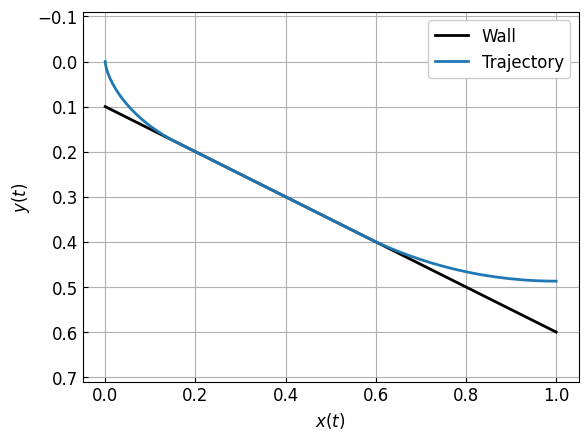

In [13]:
plt.plot(x, x / 2 + 0.1, "k", linewidth=2)
plt.plot(x, y, linewidth=2)
plt.xlabel("$x(t)$")
plt.ylabel("$y(t)$")
plt.xlim([-0.05, 1.05])
plt.ylim([0.7, -0.05])
plt.axis("equal")
plt.legend(("Wall", "Trajectory"), framealpha=1.0)
plt.grid()

It's about what we would expect. We can plot the history of each of the state variables, although that doesn't tell us quite as much as the plot above:

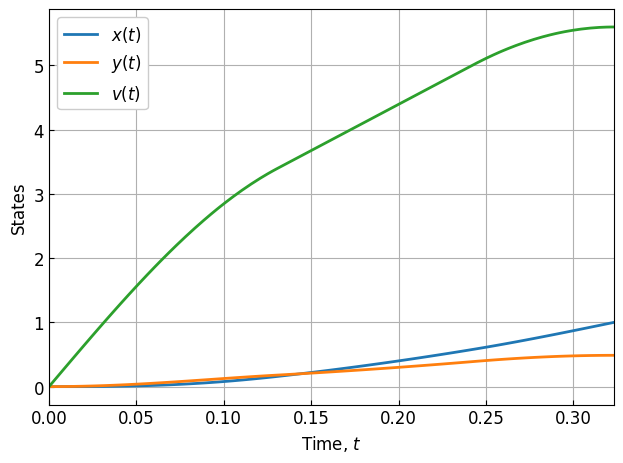

In [14]:
plt.plot(time, x, time, y, time, v, linewidth=2)
plt.xlabel("Time, $t$")
plt.ylabel("States")
plt.legend(("$x(t)$", "$y(t)$", "$v(t)$"), framealpha=1.0)
plt.xlim([t0, tf])
plt.tight_layout()
plt.grid()

Finally, let's look at the control history. Recall that the control $u(t) = \gamma(t)$ is the angle of the velocity vector below the horizontal:

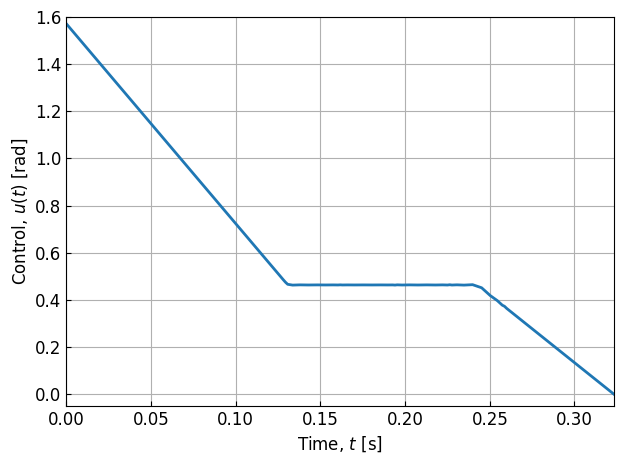

In [15]:
plt.plot(time_c, control[0], linewidth=2)
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Control, $u(t)$ [rad]")
plt.ylim([-0.05, 1.6])
plt.xlim([t0, tf])
plt.tight_layout()
plt.grid()

Note that the control history consists of three straight lines. It's known that for the solution of the unconstrained brachistochrone problem, the angle of the velocity vector $\gamma$ varies linearly with time, and so we should expect that to be the case at the beginning and end of the optimal trajectory, when the path constraint is not active. For the middle section, the angle $\gamma = 30^\circ=\pi/6\text{ rad}$, the angle of the barrier with respect to horizontal.

If you look closely at the plot above, you'll see that the corners aren't sharp. The polynomials that represent the solution have difficulty representing functions with discontinuous derivatives, as is the case here. The solution (which is already pretty good!) can be improved by mesh refinement. YAPSS does not (yet) have automatic mesh refinement, so while it's inefficient, one way to improve the solution is just to increase the mesh density everywhere. So if we use 50 segments of 10 points instead of 10 segments of 10 points, we get a much better result. (If you're reading the HMTL version, some cells are hidden just to keep it brief.)

In [16]:
# mesh geometry
segments, points = 50, 10
problem.mesh.phase[0].collocation_points = segments * [points]
problem.mesh.phase[0].fraction = segments * [1 / segments]
problem.ipopt_options.tol = 1e-14

output = problem.solve()


List of user-set options:

                                    Name   Value                used
                             mu_strategy = adaptive              yes
                      nlp_scaling_method = user-scaling          yes
                             print_level = 3                     yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
                       timing_statistics = yes                   yes
                                     tol = 1e-14                 yes
Total number of variables............................:     1951
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      451
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1500
Total number of inequality constraints...............:      452
        inequality constraints with 


Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:   3.2333116248871935e-01    3.2333116248871935e-01
Dual infeasibility......:   3.3306690738754696e-16    3.3306690738754696e-16
Constraint violation....:   1.5152323840084136e-12    1.5152323840084136e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.0000000000015730e-15    5.0000000000015730e-15
Overall NLP error.......:   1.5152323840084136e-12    1.5152323840084136e-12


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 55
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations             = 51
Total seconds in IPOPT (w/o 

function evaluations)    =      0.309
Total seconds in NLP function evaluations            =      0.230

EXIT: Solved To Acceptable Level.


In [17]:
# fmt:off
def print_solution():
    xf = 1
    tf_yapss = solution.objective
    tf_exact = sqrt(2 / g0 * (arctan(c1) + 1 / c1) * (xf + c0 / c1)) - \
               sqrt(2 * c0 / (g0 * c1) * (arctan(c1) - pi / 2 + 1 / c1))
    # fmt:on

    print(f"\nExact solution is {tf_exact = :.9f}")
    print(f"YAPSS solution is {tf_yapss = :.9f}")
    print(f"Relative error is {tf_yapss / tf_exact - 1:.3e}\n")


def plot_control():
    # extract state and control vectors, and time array
    state = solution.phase[0].state
    control = solution.phase[0].control
    time = solution.phase[0].time
    time_c = solution.phase[0].time_c
    t0 = solution.phase[0].initial_time
    tf = solution.phase[0].final_time

    x, y, v = state
    (gamma,) = control

    plt.plot(time_c, control[0], linewidth=2)
    plt.xlabel("Time, $t$ [s]")
    plt.ylabel("Control, $u(t)$ [rad]")
    plt.ylim([-0.05, 1.6])
    plt.xlim([t0, tf])
    plt.tight_layout()
    plt.grid()


Exact solution is tf_exact = 0.323331164
YAPSS solution is tf_yapss = 0.323331176
Relative error is 3.683e-08



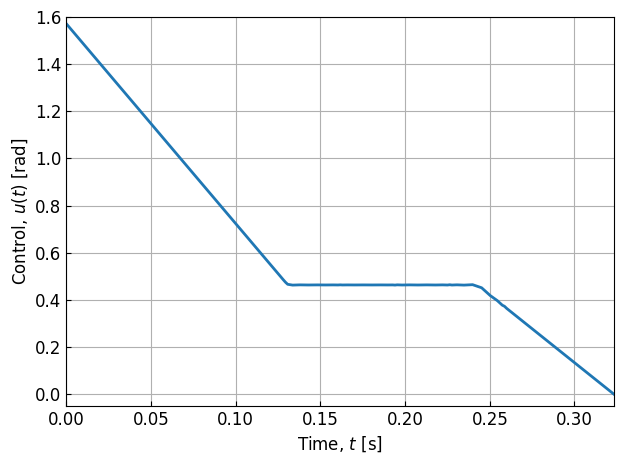

In [18]:
print_solution()
plot_control()

## The Hamiltonian

It's often useful to plot the Hamiltonian. When the Hamiltonian is not an explicit function of time (as in this problem), it should be a constant along optimal trajectories. Plotting the Hamiltonian can indicate whether there's an error in the solution — if the Hamiltonian evaluated along the optimal trajectory is non-constant or noisy, that indicates that the solution is inaccurate, either due to a *singular arc*, or because the mesh should be refined. 

(A singular arc occurs Pontryagin's minimum principle fails to determine the optimal value of the control variable. See the [Goddard problem JupyterLab notebook](./goddard_problem_1_phase.ipynb) for an example of an optimal control problem with a singular arc.)

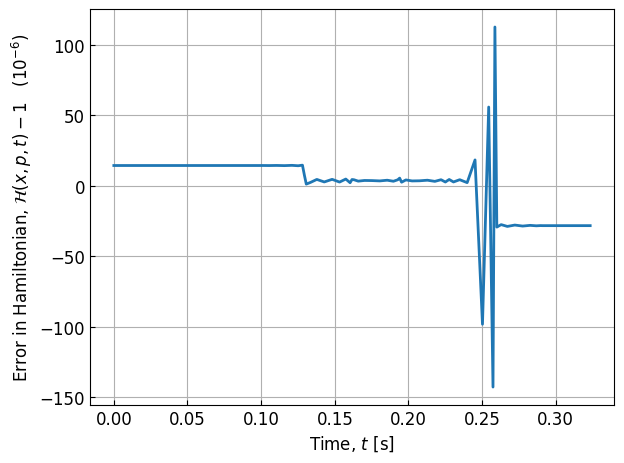

In [19]:
def plot_hamiltonian(output):
    # extract costate and dynamics vectors, and time array
    costate = solution.phase[0].costate
    dynamics = solution.phase[0].dynamics
    time_c = solution.phase[0].time_c
    hamiltonian = solution.phase[0].hamiltonian

    plt.plot(time_c, (hamiltonian + 1) * 1e6, linewidth=2)
    plt.xlabel("Time, $t$ [s]")
    plt.ylabel(r"Error in Hamiltonian, $\mathcal{H}(x,p,t)-1$   ($10^{-6}$)")
    plt.tight_layout()
    plt.grid()


plot_hamiltonian(output)

As can be seen in the plot above, the Hamiltonian is nearly constant, with a variation of only 
$\pm 8\times 10^{-6}$, which is low and does not generally indicate a significant problem. There is clearly some variation in the Hamiltonian at times corresponding to discontinuities in the derivative of the control input, and that's to be expected. For most applications, this level of accuracy is sufficient; however, refining the mesh in the vicinity of the discontinuities could improve solution accuracy.

## Conclusion

For more examples of varying complexity, refer to the [JupyterLab notebook examples](index.rst). More details of the YAPSS interface can be found in the Reference section of this user guide.

## References